In [ ]:
#import libs

import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime

d:\Coding\Python\ML\TimeSeries\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# configuration

TICKER = 'AAPL'
START_DATE = '2020-01-01'
END_DATE = '2024-12-31'
TRAIN_SPLIT = 0.80
TIME_STEP = 100
LSTM_EPOCHS = 50
HIDDEN_SIZE = 100

In [ ]:
# LSTM definition
class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions


In [4]:
# Function to create sequences for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

def fetch_stock_data(ticker_symbol, start, end):
    """Fetch stock data from Yahoo Finance"""
    try:
        print(f"Fetching data for {ticker_symbol}...")
        data = yf.download(ticker_symbol, start=start, end=end, progress=False)
        if data.empty:
            print("No data retrieved!")
            return None
        data = data[['Close']].reset_index()
        print(f"Successfully fetched {len(data)} days of data")
        return data
    except Exception as e:
        print(f"Error fetching data: {str(e)}")
        return None

def train_lstm_model(X_train_tensor, y_train_tensor, hidden_size, epochs):
    """Train LSTM model"""
    print("\n=== Training LSTM Model ===")
    model = StockLSTM(hidden_layer_size=hidden_size)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for i in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_tensor)
        loss = loss_function(y_pred, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 10 == 0:
            print(f'Epoch {i + 1}/{epochs}, Loss: {loss.item():.6f}')
    
    print("LSTM training completed!")
    return model

STOCK PRICE PREDICTION SYSTEM
Fetching data for AAPL...


C:\Users\aryad\AppData\Local\Temp\ipykernel_7808\1676903334.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker_symbol, start=start, end=end, progress=False)


Successfully fetched 1257 days of data

=== Preprocessing Data ===
Total samples: 1257
Training samples: 1005
Testing samples: 252

=== Training LSTM Model ===
Epoch 10/50, Loss: 0.056036
Epoch 20/50, Loss: 0.010462
Epoch 30/50, Loss: 0.012063
Epoch 40/50, Loss: 0.010695
Epoch 50/50, Loss: 0.009304
LSTM training completed!

=== Making LSTM Predictions ===

=== Training Prophet Model ===


17:48:34 - cmdstanpy - INFO - Chain [1] start processing
17:48:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\aryad\AppData\Local\Temp\ipykernel_7808\1240195026.py:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"Current Price:      ${float(data['Close'].iloc[-1]):.2f}")
C:\Users\aryad\AppData\Local\Temp\ipykernel_7808\1240195026.py:104: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"Highest Price:      ${float(data['Close'].max()):.2f}")
C:\Users\aryad\AppData\Local\Temp\ipykernel_7808\1240195026.py:105: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"Lowest Price:       ${float(data['Close'].min()):.2f}")
C:\Users\aryad\AppData\Local\Temp\ipykernel_7808\1240

Prophet training completed!

MODEL PERFORMANCE METRICS
LSTM Train RMSE:    $19.54
LSTM Test RMSE:     $61.82
Prophet Test RMSE:  $16.27

Best Model: Prophet (RMSE difference: $45.56)

DATA STATISTICS
Stock Ticker:       AAPL
Date Range:         2020-01-02 to 2024-12-30
Total Days:         1257
Current Price:      $251.31
Highest Price:      $258.10
Lowest Price:       $54.32
Average Price:      $151.73

=== Generating Visualization ===
Displaying visualization...


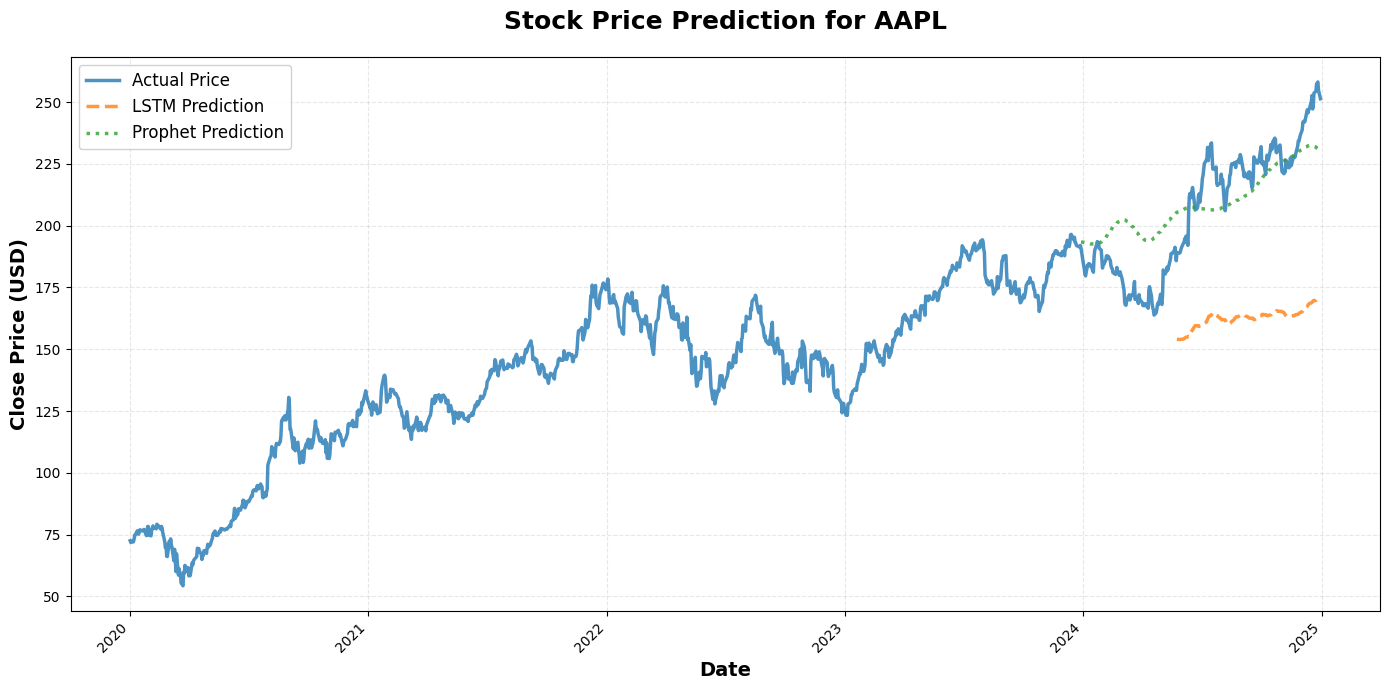


ANALYSIS COMPLETE


In [6]:
def main():
    print("="*60)
    print("STOCK PRICE PREDICTION SYSTEM")
    print("="*60)
    
    # Fetch data
    data = fetch_stock_data(TICKER, START_DATE, END_DATE)
    
    if data is None or len(data) < TIME_STEP + 50:
        print("Error: Insufficient data retrieved")
        return
    
    # Data preprocessing
    print("\n=== Preprocessing Data ===")
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    
    training_size = int(len(data_scaled) * TRAIN_SPLIT)
    test_size = len(data_scaled) - training_size
    train_data = data_scaled[0:training_size, :]
    test_data = data_scaled[training_size:len(data_scaled), :1]
    
    print(f"Total samples: {len(data_scaled)}")
    print(f"Training samples: {training_size}")
    print(f"Testing samples: {test_size}")
    
    # Create datasets
    X_train, y_train = create_dataset(train_data, TIME_STEP)
    X_test, y_test = create_dataset(test_data, TIME_STEP)
    
    if len(X_test) == 0:
        print("Error: Insufficient test data")
        return
    
    # Reshape for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Convert to tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)
    
    # Train LSTM
    model = train_lstm_model(X_train_tensor, y_train_tensor, HIDDEN_SIZE, LSTM_EPOCHS)
    
    # LSTM Predictions
    print("\n=== Making LSTM Predictions ===")
    model.eval()
    with torch.no_grad():
        train_predict = model(X_train_tensor).numpy()
        test_predict = model(X_test_tensor).numpy()
    
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    y_train_orig = scaler.inverse_transform(y_train_tensor.numpy())
    y_test_orig = scaler.inverse_transform(y_test_tensor.numpy())
    
    # Train Prophet Model
    print("\n=== Training Prophet Model ===")
    prophet_data = data[['Date', 'Close']].copy()
    prophet_data.columns = ['ds', 'y']
    prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])
    prophet_data['y'] = prophet_data['y'].astype(float)
    
    prophet_train = prophet_data.iloc[:training_size].reset_index(drop=True)
    prophet_test = prophet_data.iloc[training_size:].reset_index(drop=True)
    
    prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=False)
    prophet_model.fit(prophet_train)
    
    future = prophet_model.make_future_dataframe(periods=len(prophet_test))
    forecast = prophet_model.predict(future)
    prophet_predictions = forecast['yhat'].iloc[-len(prophet_test):].values
    
    print("Prophet training completed!")
    
    # Performance Metrics
    print("\n" + "="*60)
    print("MODEL PERFORMANCE METRICS")
    print("="*60)
    
    lstm_train_rmse = np.sqrt(mean_squared_error(y_train_orig, train_predict))
    lstm_test_rmse = np.sqrt(mean_squared_error(y_test_orig, test_predict))
    prophet_test_rmse = np.sqrt(mean_squared_error(prophet_test['y'].values, prophet_predictions))
    
    print(f"LSTM Train RMSE:    ${lstm_train_rmse:.2f}")
    print(f"LSTM Test RMSE:     ${lstm_test_rmse:.2f}")
    print(f"Prophet Test RMSE:  ${prophet_test_rmse:.2f}")
    
    best_model = "LSTM" if lstm_test_rmse < prophet_test_rmse else "Prophet"
    improvement = abs(lstm_test_rmse - prophet_test_rmse)
    print(f"\nBest Model: {best_model} (RMSE difference: ${improvement:.2f})")
    
    # Data Statistics
    print("\n" + "="*60)
    print("DATA STATISTICS")
    print("="*60)
    print(f"Stock Ticker:       {TICKER}")
    print(f"Date Range:         {data['Date'].min().strftime('%Y-%m-%d')} to {data['Date'].max().strftime('%Y-%m-%d')}")
    print(f"Total Days:         {len(data)}")
    print(f"Current Price:      ${float(data['Close'].iloc[-1]):.2f}")
    print(f"Highest Price:      ${float(data['Close'].max()):.2f}")
    print(f"Lowest Price:       ${float(data['Close'].min()):.2f}")
    print(f"Average Price:      ${float(data['Close'].mean()):.2f}")
    
    # Visualization
    print("\n=== Generating Visualization ===")
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot actual prices
    ax.plot(data['Date'], data['Close'], label='Actual Price', color='#1f77b4', linewidth=2.5, alpha=0.8)
    
    # LSTM predictions
    test_start_idx = training_size + TIME_STEP + 1
    lstm_test_dates = data['Date'].iloc[test_start_idx:test_start_idx + len(test_predict)]
    
    if len(lstm_test_dates) == len(test_predict):
        ax.plot(lstm_test_dates, test_predict.flatten(), label='LSTM Prediction', 
                color='#ff7f0e', linewidth=2.5, linestyle='--', alpha=0.8)
    
    # Prophet predictions
    if len(prophet_test['ds']) == len(prophet_predictions):
        ax.plot(prophet_test['ds'], prophet_predictions, label='Prophet Prediction', 
                color='#2ca02c', linewidth=2.5, linestyle=':', alpha=0.8)
    
    ax.set_title(f'Stock Price Prediction for {TICKER}', fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax.set_ylabel('Close Price (USD)', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=12, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    print("Displaying visualization...")
    plt.show()
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE")
    print("="*60)

if __name__ == "__main__":
    main()